### Set up libraries

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
from typing import Dict, Tuple
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import thundersvm

import jax
import jax.numpy as jnp
from jax.interpreters import xla
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_platform_name", "cpu")

import neural_tangents as nt
from neural_tangents import stax

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

[GpuDevice(id=0, task=0)]

In [3]:
import sys
sys.path.append("../../..")

from adversarial_ntks import dataset, attacks, jthunder, kernel

### Load Data

In [4]:
%%time

MNIST_TRAIN = dataset.get_np_data(
    name="mnist", split="train", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))
MNIST_TEST = dataset.get_np_data(
    name="mnist", split="test", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))

print(MNIST_TRAIN.xs.shape)
print(MNIST_TEST.xs.shape)

(60000, 784)
(10000, 784)
CPU times: user 11.5 s, sys: 14.4 s, total: 25.9 s
Wall time: 4.88 s


[0 0 0 1 1 0 0 1 0 1]


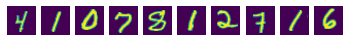

[0 0 0 1 1 1 0 1 0 0]


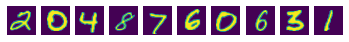

In [5]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)

### Utility code

In [6]:
def avg_by_cls(xs, ys) -> Tuple[float, float]:
    return (xs[ys == 0].mean(), xs[ys == 1].mean())

def accs_by_cls(clf: thundersvm.SVC, ds: dataset.Dataset) -> Tuple[float, float]:
    return avg_by_cls(clf.predict(ds.xs) == ds.ys, ds.ys)

def fmt_accs(accs: Tuple) -> str:
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

def print_dict(d: Dict):
    def fmt(v):
            if isinstance(v, tuple):
                return fmt_accs(v)
            elif isinstance(v, float):
                return f"{v:.2e}"
            return v
            
    print({
        k : fmt(v) for
        k, v in d.items()
        if not isinstance(v, np.ndarray)
    })
    
def print_clf_info(clf: thundersvm.SVC):
    print_dict(dict(
        n_support=list(clf.n_support_),
        b=clf.intercept_[0],
        gam=clf._gamma,
        coef0=clf.coef0,
    ))

In [7]:
def eval_ds(
    clf: thundersvm.SVC,
    ds: dataset.Dataset,
    attack_norm: int,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    batch_size: int
) -> Dict:
    res_dict = dict()
    
    res_dict["accs_nat"] = accs_by_cls(clf=clf, ds=ds)
    res_dict["acc_nat"] = sum(res_dict["accs_nat"]) / 2
    print(f"accs_nat: {fmt_accs(res_dict['accs_nat'])}")
    print(f"acc_nat: {res_dict['acc_nat']:.4f}")
    
    clf_grad_fn = jthunder.get_grad_decision_function(clf)
    
    xs_pgd = attacks.pgd(
        X=ds.xs, Y=ds.ys,
        grad_func=clf_grad_fn,
        eps=attack_eps, eps_norm=attack_norm,
        step_size=pgd_step_size, step_norm=attack_norm,
        num_steps=pgd_num_steps,
        pixel_clip=True,
        batch_size=batch_size,
    )
    res_dict["xs_pgd"] = xs_pgd
    
    res_dict["preds_pgd"] = clf.predict(xs_pgd)
    res_dict["accs_pgd"] = accs_by_cls(clf=clf, ds=ds.replace_xs(xs_pgd))
    res_dict["acc_pgd"] = sum(res_dict["accs_pgd"]) / 2
    print(f"accs_pgd: {fmt_accs(res_dict['accs_pgd'])}")
    print(f"acc_pgd: {res_dict['acc_pgd']:.4f}")
    
    return res_dict

# Begin experiments

In [8]:
RESULTS = {}

### Linear kernel - MNIST

In [9]:
%%time
clf = thundersvm.SVC(kernel="linear", C=1e-1)
clf.fit(MNIST_TRAIN.xs, MNIST_TRAIN.ys)

RESULTS["linear"] = dict(clf=clf)

CPU times: user 57.4 s, sys: 0 ns, total: 57.4 s
Wall time: 58.7 s


In [10]:
print_clf_info(RESULTS["linear"]["clf"])

{'n_support': [10127, 10125], 'b': '-9.37e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00'}


In [11]:
%%time
RESULTS["linear"].update(eval_ds(
    clf=RESULTS["linear"]["clf"],
    ds=MNIST_TEST,
    attack_norm=2,
    attack_eps=2,
    pgd_step_size=2/10,
    pgd_num_steps=20,
    batch_size=256,
))

accs_nat: (0.8809, 0.8805)
acc_nat: 0.8807


  0%|          | 0/40 [00:00<?, ?it/s]

accs_pgd: (0.0000, 0.0012)
acc_pgd: 0.0006
CPU times: user 32.1 s, sys: 0 ns, total: 32.1 s
Wall time: 31.9 s


Nat data
[0 0 0 1 1 1 0 1 0 0]


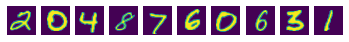

PGD data
[0 0 0 1 1 1 0 1 0 0]


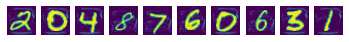

PGD preds
[1 1 1 0 0 0 1 0 1 1]


In [12]:
print("Nat data")
dataset.plot_images(MNIST_TEST, channels=1)

print("PGD data")
dataset.plot_images(
    dataset.Dataset(
        xs=RESULTS["linear"]["xs_pgd"],
        ys=MNIST_TEST.ys,
        one_hot=False,
        num_classes=2,
    ), channels=1
)
print("PGD preds")
print(RESULTS["linear"]["preds_pgd"][:10].astype(int))

### Poly kernel - MNIST

In [13]:
%%time
clf = thundersvm.SVC(kernel="polynomial", degree=2, C=1000, coef0=1)
clf.fit(MNIST_TRAIN.xs, MNIST_TRAIN.ys)

RESULTS["poly"] = dict(clf=clf)

CPU times: user 2min 58s, sys: 0 ns, total: 2min 58s
Wall time: 3min 2s


In [14]:
print_clf_info(RESULTS["poly"]["clf"])

{'n_support': [2745, 2810], 'b': '-1.49e+00', 'gam': '1.28e-03', 'coef0': 1}


In [15]:
#%%time
#RESULTS["poly"]["clf"].save_to_file("models/thundersvm/poly-mnist.thunder")

In [16]:
%%time
RESULTS["poly"].update(eval_ds(
    clf=RESULTS["poly"]["clf"],
    ds=MNIST_TEST,
    attack_norm=2,
    attack_eps=2,
    pgd_step_size=2/10,
    pgd_num_steps=20,
    batch_size=256,
))

accs_nat: (0.9776, 0.9733)
acc_nat: 0.9754


  0%|          | 0/40 [00:00<?, ?it/s]

accs_pgd: (0.0000, 0.0000)
acc_pgd: 0.0000
CPU times: user 19.3 s, sys: 0 ns, total: 19.3 s
Wall time: 18.8 s


Nat data
[0 0 0 1 1 1 0 1 0 0]


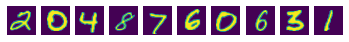

PGD data
[0 0 0 1 1 1 0 1 0 0]


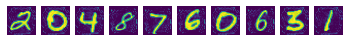

PGD preds
[1 1 1 0 0 0 1 0 1 1]


In [17]:
print("Nat data")
dataset.plot_images(MNIST_TEST, channels=1)

print("PGD data")
dataset.plot_images(
    dataset.Dataset(
        xs=RESULTS["poly"]["xs_pgd"],
        ys=MNIST_TEST.ys,
        one_hot=False,
        num_classes=2,
    ), channels=1
)
print("PGD preds")
print(RESULTS["poly"]["preds_pgd"][:10].astype(int))

### RBF kernel - MNIST

In [18]:
%%time
clf = thundersvm.SVC(kernel="rbf", C=1000)
clf.fit(MNIST_TRAIN.xs, MNIST_TRAIN.ys)

RESULTS["rbf"] = dict(clf=clf)

CPU times: user 2min 30s, sys: 92.7 ms, total: 2min 30s
Wall time: 2min 34s


In [19]:
print_clf_info(RESULTS["rbf"]["clf"])

{'n_support': [2665, 2854], 'b': '-3.00e+01', 'gam': '1.28e-03', 'coef0': '0.00e+00'}


In [20]:
#%%time
#RESULTS["rbf"]["clf"].save_to_file("models/thundersvm/rbf-mnist.thunder")

In [21]:
%%time
RESULTS["rbf"].update(eval_ds(
    clf=RESULTS["rbf"]["clf"],
    ds=MNIST_TEST,
    attack_norm=2,
    attack_eps=2,
    pgd_step_size=2/10,
    pgd_num_steps=20,
    batch_size=256,
))

accs_nat: (0.9792, 0.9753)
acc_nat: 0.9772


  0%|          | 0/40 [00:00<?, ?it/s]

accs_pgd: (0.0000, 0.0000)
acc_pgd: 0.0000
CPU times: user 1min, sys: 1.61 s, total: 1min 1s
Wall time: 1min


Nat data
[0 0 0 1 1 1 0 1 0 0]


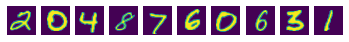

PGD data
[0 0 0 1 1 1 0 1 0 0]


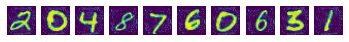

PGD preds
[1 1 1 0 0 0 1 0 1 1]


In [22]:
print("Nat data")
dataset.plot_images(MNIST_TEST, channels=1)

print("PGD data")
dataset.plot_images(
    dataset.Dataset(
        xs=RESULTS["rbf"]["xs_pgd"],
        ys=MNIST_TEST.ys,
        one_hot=False,
        num_classes=2,
    ), channels=1
)
print("PGD preds")
print(RESULTS["rbf"]["preds_pgd"][:10].astype(int))